## Ví dụ trên Python
Khai báo các thư viện cần dùng.

In [197]:
from __future__ import print_function 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from matplotlib.backends.backend_pdf import PdfPages
import random
np.random.seed(18)

Tạo dữ liệu bằng cách lấy các điểm theo phân phối chuẩn có kỳ vọng tại `(2, 2), (8, 3)` và `(3, 6)`, ma trận hiệp phương sai giống nhau và là ma trận đơn vị. Mỗi cụm có 500 điểm. Hiển thị các cụm điểm trên đồ thị.

In [198]:
means = [[2, 2], [8, 3], [3, 6]]
cov = [[1, 0], [0, 1]]
N = 500
X0 = np.random.multivariate_normal(means[0], cov, N)
X1 = np.random.multivariate_normal(means[1], cov, N)
X2 = np.random.multivariate_normal(means[2], cov, N)

X = np.concatenate((X0, X1, X2), axis = 0)
K = 3

original_label = np.asarray([0]*N + [1]*N + [2]*N).T

Viết hàm `kmeans_display` để hiển thị dữ liệu. Sau đó hiển thị dữ liệu theo nhãn ban đầu.

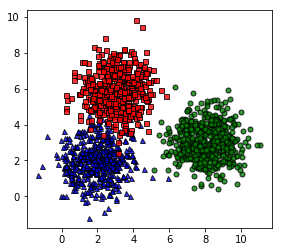

In [199]:
def kmeans_display(X, label, filename = 'data.pdf'):
    X0 = X[label == 0, :]
    X1 = X[label == 1, :]
    X2 = X[label == 2, :]
    
    with PdfPages(filename) as pdf:       
        kwargs = {"markersize": 5, "alpha": .8, "markeredgecolor": 'k'}
        plt.plot(X0[:, 0], X0[:, 1], 'b^', **kwargs)
        plt.plot(X1[:, 0], X1[:, 1], 'go', **kwargs)
        plt.plot(X2[:, 0], X2[:, 1], 'rs', **kwargs)

        plt.axis([-3, 14, -2, 10])
        plt.axis('scaled')
        plt.plot()
        pdf.savefig(bbox_inches='tight')
        plt.show()
    
kmeans_display(X, original_label)

Viết các hàm:
1. `kmeans_init_centroids` để khởi tạo các điểm đại diện ban đầu.
2. `kmeans_asign_labels` để gán nhán mới cho các điểm tương ứng với các điểm đại diện.
3. `kmeans_update_centroids` để cập nhật các điểm đại diện mới dữa trên dữ liệu vừa được gán nhãn.
4. `há_converged` để kiểm tra điều kiện dừng của thuật toán.

In [200]:
def kmeans_init_centroids(X, k):
    # randomly pick k rows of X ans initial centroids
    return X[np.random.choice(X.shape[0], k)]

def kmeans_assign_labels(X, centroids):
    # calculate pairwise distances btw data and centroids
    D = cdist(X, centroids)
    # return index of the closest centroid
    return np.argmin(D, axis = 1)

def kmeans_update_centroids(X, labels, K):
    centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        # collect all points assigned to the k-th cluster 
        Xk = X[labels == k, :]
        # take average
        centroids[k,:] = np.mean(Xk, axis = 0)
    return centroids

def has_converged(centroids, new_centroids):
    # return True if two sets of centroids as the same
    return (set([tuple(a) for a in centroids]) == set([tuple(a) for a in new_centroids]))

Phần chính của K-means Clustering.

In [201]:
def kmeans(X, K):
    centroids = [kmeans_init_centroids(X, K)]
    labels = []
    it = 0 
    while True:
        labels.append(kmeans_assign_labels(X, centroids[-1]))
        new_centroids = kmeans_update_centroids(X, labels[-1], K)
        if has_converged(centroids[-1], new_centroids):
        	break
        centroids.append(new_centroids)
        it += 1
    return (centroids, labels, it)

Áp dụng thuật toán vừa viết vào dữ liệu ban đầu, hiển thị kết quả cuối cùng. 

Centers found by our algorithm:
 [[ 3.02702878  5.95686115]
 [ 1.9834967   1.96588127]
 [ 8.07476866  3.01494931]]


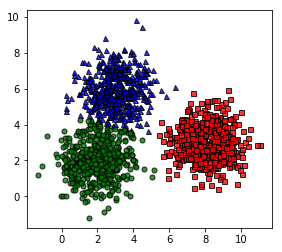

In [206]:
(centroids, labels, it) = kmeans(X, K)
print('Centers found by our algorithm:\n', centroids[-1])
kmeans_display(X, labels[-1], 'res.pdf')

Từ kết quả này chúng ta thấy rằng thuật toán K-means Clustering làm việc khá thành công, các centroids tìm được khá gần với kỳ vọng ban đầu. Mặc dù màu sắc của hai nhóm xanh, đỏ đã bị hoán đổi nhưng những điểm ban đầu thuộc cùng một cluster gần như vẫn cùng thuộc một cluster.

### Kết quả tìm được bằng thư viện scikit-learn


Centers found by scikit-learn:
[[ 8.07476866  3.01494931]
 [ 3.02702878  5.95686115]
 [ 1.9834967   1.96588127]]


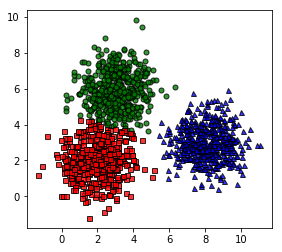

In [187]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3, random_state=0).fit(X)
print('Centers found by scikit-learn:')
print(model.cluster_centers_)
pred_label = model.predict(X)
kmeans_display(X, pred_label, 'res_scikit.pdf')

Chúng ta thấy rằng hai thuật toán khác nhau cho cùng một đáp số. Với cách thứ nhất, tôi mong muốn các bạn hiểu rõ được thuật toán. Với cách thứ hai, tôi hy vọng các bạn biết áp dụng thư viện sẵn có như thế nào.

# Hiển thị kết quả sau mỗi vòng lặp 

## Voronoi


In [193]:
from voronoi import voronoi_finite_polygons_2d
vor = Voronoi(centroids[-1])
def kmeans_display_progress(X, centroids, labels, it, filename = 'ex.pdf', saving = False):
    label = labels[it] # label at iteration it 
    X0 = X[label == 0, :]
    X1 = X[label == 1, :]
    X2 = X[label == 2, :]
    
#     filename = pre + '_' + str(it) + '.pdf'
    with PdfPages(filename) as pdf:
        # draw data points with color 
        kwargs = {"markersize": 5, "alpha": 1, "markeredgecolor": 'k'}
        plt.plot(X0[:, 0], X0[:, 1], 'b^', **kwargs)
        plt.plot(X1[:, 0], X1[:, 1], 'go', **kwargs)
        plt.plot(X2[:, 0], X2[:, 1], 'rs', **kwargs)

        # draw centroids 
        points = centroids[it]
        kwargs = {"markersize": 15, "markeredgecolor": 'k'}
        animlist = plt.plot(points[0, 0], points[0, 1], 'y^', **kwargs)
        animlist = plt.plot(points[1, 0], points[1, 1], 'yo', **kwargs)
        animlist = plt.plot(points[2, 0], points[2, 1], 'ys', **kwargs)

        # draw color for each voronoi region 
        colors = ['b', 'g', 'r']

        vor = Voronoi(points)
        regions, vertices = voronoi_finite_polygons_2d(vor, radius = 1000)
        for i,region in enumerate(regions):
            polygon = vertices[region]
            animlist = plt.fill(*zip(*polygon), alpha=.2, color = colors[i])
        plt.axis('scaled')
        plt.title('iteration: %d/%d' %(it+1, len(labels)))
        plt.axis([-2, 11, -2, 10])
        if saving:
            pdf.savefig(bbox_inches='tight')
        plt.show()




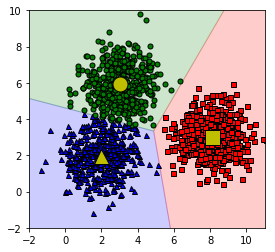

In [191]:
iters = range(5,6)
for it in iters:
    filename = 'ex_' + str(it) + 'notitle.pdf'
    kmeans_display_progress(X, centroids, labels, it, filename, saving = True)

# Slow convergence 

In [175]:
for i in range(6):
    np.random.seed(9*i)
    (centroids, labels, it) = kmeans(X, K)
    print('seed number:', 9*i, 'number of iterations:', len(labels))

seed number: 0 number of iterations: 8
seed number: 9 number of iterations: 8
seed number: 18 number of iterations: 9
seed number: 27 number of iterations: 20
seed number: 36 number of iterations: 7
seed number: 45 number of iterations: 8


Từ đây ta có thể thấy rằng với các khởi tạo khác nhau, số lượng vòng lặp là khác nhau. 

# Nghiệm tìm được không như nhau 


In [154]:
for i in range(60):
    np.random.seed(i)
    (centroids, labels, it) = kmeans(X, K)
    print(centroids[-1])
#     print('seed number:', 9*i, 'number of iterations:', len(labels))





[[ 8.78046073  2.78155578]
 [ 7.15025799  3.32261946]
 [ 2.48627752  3.975271  ]]
[[ 3.02702878  5.95686115]
 [ 1.9834967   1.96588127]
 [ 8.07476866  3.01494931]]
[[ 3.02702878  5.95686115]
 [ 8.07476866  3.01494931]
 [ 1.9834967   1.96588127]]
[[ 3.02702878  5.95686115]
 [ 8.07476866  3.01494931]
 [ 1.9834967   1.96588127]]
[[ 3.02702878  5.95686115]
 [ 8.07476866  3.01494931]
 [ 1.9834967   1.96588127]]
[[ 8.07476866  3.01494931]
 [ 1.9834967   1.96588127]
 [ 3.02702878  5.95686115]]
[[ 3.02702878  5.95686115]
 [ 8.07476866  3.01494931]
 [ 1.9834967   1.96588127]]
[[ 1.9834967   1.96588127]
 [ 3.02702878  5.95686115]
 [ 8.07476866  3.01494931]]
[[ 8.07476866  3.01494931]
 [ 3.02702878  5.95686115]
 [ 1.9834967   1.96588127]]
[[ 1.9834967   1.96588127]
 [ 3.02702878  5.95686115]
 [ 8.07476866  3.01494931]]
[[ 1.9834967   1.96588127]
 [ 3.02702878  5.95686115]
 [ 8.07476866  3.01494931]]
[[ 1.9834967   1.96588127]
 [ 3.02702878  5.95686115]
 [ 8.07476866  3.01494931]]
[[ 1.9834967   1

10


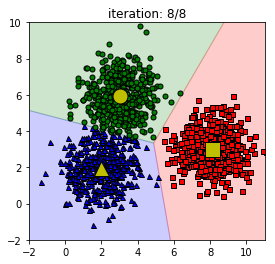

31


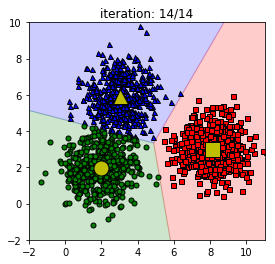

27


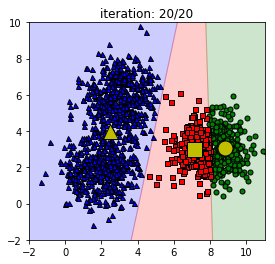

In [212]:
for i in [10, 31, 27]:
    np.random.seed(i)
    (centroids, labels, it) = kmeans(X, K)
    it = len(labels) - 1
    print(i)
    filename = 'dif_res' + str(i) + '.pdf'
    kmeans_display_progress(X, centroids, labels, it, filename, saving = True)

# Số lượng điểm chênh lệch

10


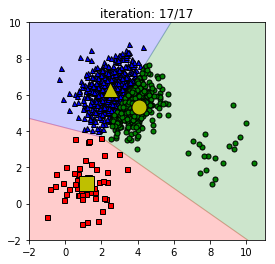

In [224]:
means = [[1, 1], [8, 3], [3, 6]]
cov = [[1, 0], [0, 1]]
N = [50, 20, 1000]
X0 = np.random.multivariate_normal(means[0], cov, N[0])
X1 = np.random.multivariate_normal(means[1], cov, N[1])
X2 = np.random.multivariate_normal(means[2], cov, N[2])

X = np.concatenate((X0, X1, X2), axis = 0)
K = 3

# original_label = np.asarray([0]*N + [1]*N + [2]*N).T

for i in [10]:
    np.random.seed(i)
    (centroids, labels, it) = kmeans(X, K)
    it = len(labels) - 1
    print(i)
    filename = 'skew_' + str(i) + '.pdf'
    kmeans_display_progress(X, centroids, labels, it, filename, saving = True)

# Các cluster không có dạng tròn 


10


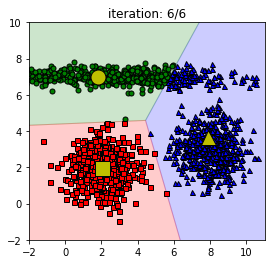

In [227]:
means = [[2, 2], [8, 3], [3, 7]]
cov = [[1, 0], [0, 1]]
cov2 = [[10, 0], [0, .1]]

N = [500, 500, 500]
X0 = np.random.multivariate_normal(means[0], cov, N[0])
X1 = np.random.multivariate_normal(means[1], cov, N[1])
X2 = np.random.multivariate_normal(means[2], cov2, N[2])

X = np.concatenate((X0, X1, X2), axis = 0)
K = 3

# original_label = np.asarray([0]*N + [1]*N + [2]*N).T

for i in [10]:
    np.random.seed(i)
    (centroids, labels, it) = kmeans(X, K)
    it = len(labels) - 1
    print(i)
    filename = 'notround_' + str(i) + '.pdf'
    kmeans_display_progress(X, centroids, labels, it, filename, saving = True)